# First Quantum Layers: Classifying Iris with MerLin

This pedagogical notebook walks through three complementary ways to instantiate and train `QuantumLayer` objects on the Iris classification task. It combines explanations from the Quickstart and the "Your First Quantum Layer" guide so you understand both the code and the design decisions.

Learning objectives

- See three construction styles: a quick factory, the high-level `CircuitBuilder`, and a hand-crafted `perceval.Circuit`.
- Understand encoding choices (angle vs amplitude), measurement strategies, and computation spaces.
- Learn how to reduce the high-dimensional Fock outputs to classical features using grouping modules such as `LexGrouping` and `ModGrouping`.

Notes

- This notebook is intentionally compact: each example reuses the same dataset and optimisation loop so you can focus on circuit design differences.
- If you are new to photonic simulation, review the "Basic Concepts" section in the docs for background on modes, photons and components.

We will reuse a common data pipeline and optimisation loop while switching between three APIs:

1. `QuantumLayer.simple` — a quick factory that builds a ready-to-train 10-mode / 5-photon circuit.
2. Declarative `CircuitBuilder` — a fluent, repeatable way to assemble encoders, entangling blocks and superpositions.
3. A fully manual `perceval.Circuit` — for maximum control when you need custom detector or experimental behaviour.

Along the way we emphasise the choices that impact training and runtime: encoding (angle vs amplitude), measurement strategy (probabilities / mode expectations / amplitudes), and computation space (FOCK / UNBUNCHED / DUAL_RAIL).

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from merlin import LexGrouping, QuantumLayer, MeasurementStrategy, ComputationSpace
from merlin.builder import CircuitBuilder
import perceval as pcvl

torch.manual_seed(0)
np.random.seed(0)

iris = load_iris()
X = iris.data.astype("float32")
y = iris.target.astype("int64")

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 112 samples
Test size: 38 samples


In [3]:
# here is a function to run an experiment : train and evaluate a QuantumLayer


def run_experiment(layer: torch.nn.Module, epochs: int = 60, lr: float = 0.05):
    optimizer = torch.optim.Adam(layer.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        layer.train()
        optimizer.zero_grad()
        logits = layer(X_train)
        loss = F.cross_entropy(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    layer.eval()
    with torch.no_grad():
        train_preds = layer(X_train).argmax(dim=1)
        test_preds = layer(X_test).argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()
        test_acc = (test_preds == y_test).float().mean().item()
    return losses, train_acc, test_acc


def describe(name: str, losses, train_acc: float, test_acc: float):
    print(name)
    print(f"  epochs: {len(losses)}")
    print(f"  final loss: {losses[-1]:.4f}")
    print(f"  train accuracy: {train_acc:.3f}")
    print(f"  test accuracy: {test_acc:.3f}")

## 1. Quickstart factory: `QuantumLayer.simple`

The `simple` factory constructs a compact, ready-to-train photonic layer (default: 10 modes, 5 photons). Use it when you want a sensible default architecture to prototype quickly. The helper:

- creates an entangling interferometer, an input angle-encoding stage, optional trainable MZI blocks, and final superpositions;
- exposes a predictable number of trainable parameters so you can compare capacities;
- returns a PyTorch `nn.Module` you can plug into standard training loops.

We use `LexGrouping` after the quantum core to collapse the Fock distribution into a small number of classical features suitable for a linear classifier.

In [4]:
base_simple = QuantumLayer.simple(
    input_size=X_train.shape[1],
    n_params=100,
    dtype=X_train.dtype,
)

simple_layer = nn.Sequential(
    base_simple,
    LexGrouping(base_simple.output_size, 3),
)

losses, train_acc, test_acc = run_experiment(simple_layer, epochs=80, lr=0.01)
trainable = sum(p.numel() for p in simple_layer.parameters() if p.requires_grad)
describe("QuantumLayer.simple", losses, train_acc, test_acc)
print(
    f"  trainable parameters: {trainable}"
)  # this will also print the number of trainable parameters in the last Linear layer

# this circuit does not work well on this dataset, let us try another circuit !

QuantumLayer.simple
  epochs: 80
  final loss: 0.7972
  train accuracy: 0.884
  test accuracy: 0.842
  trainable parameters: 100


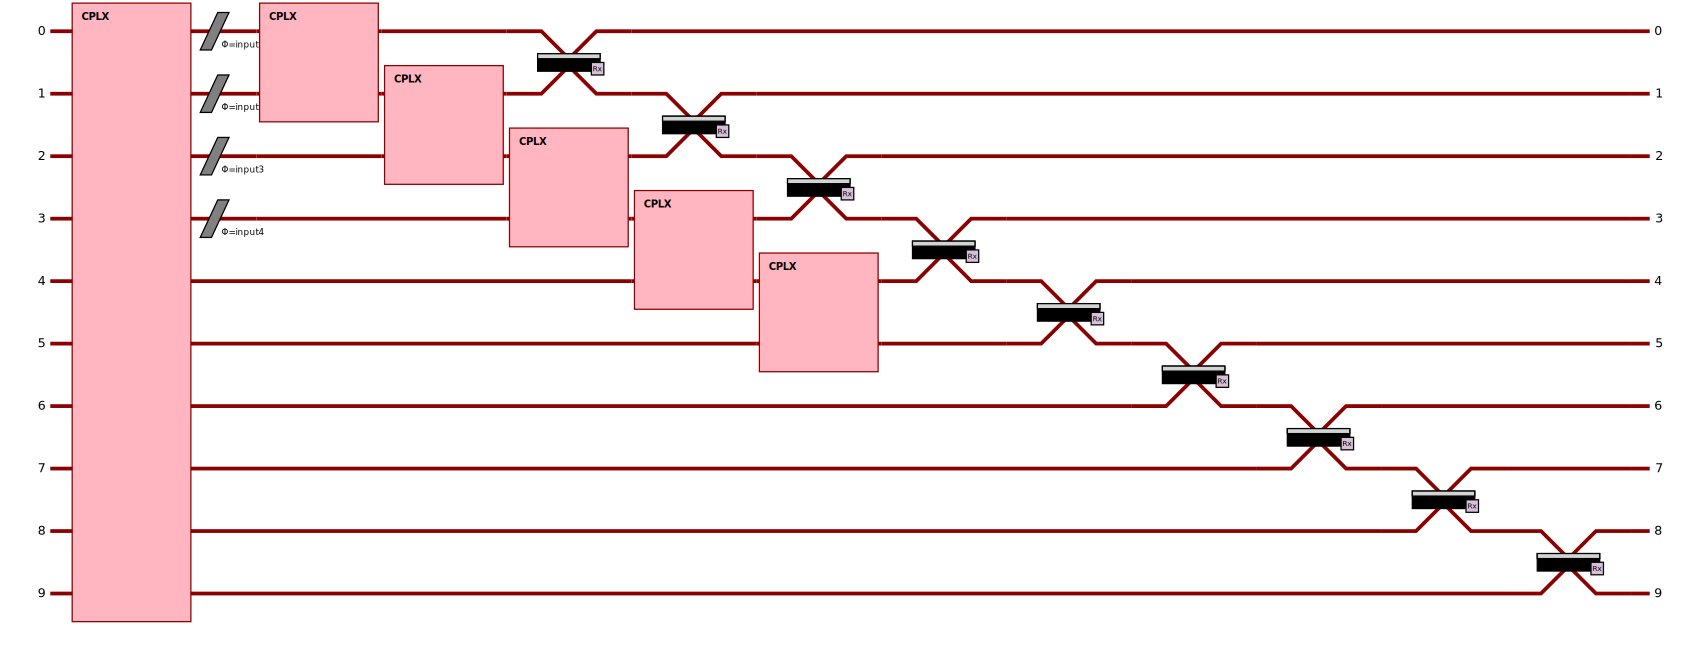

In [5]:
# you can visualize the circuit generated by QuantumLayer.simple
pcvl.pdisplay(base_simple.circuit)

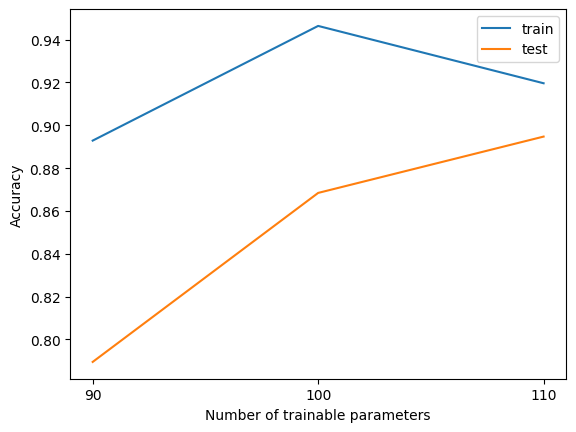

In [9]:
params = [90, 100, 110]
test_accs, train_accs = [], []
for n_params in params:
    base_layer = QuantumLayer.simple(
        input_size=X_train.shape[1],
        n_params=n_params,
        dtype=X_train.dtype,
    )
    simple_layer = nn.Sequential(
        base_layer,
        LexGrouping(base_layer.output_size, 3),
    )
    losses, train_acc, test_acc = run_experiment(simple_layer, epochs=80, lr=0.01)
    test_accs.append(test_acc)
    train_accs.append(train_acc)
plt.plot(params, train_accs, label="train")
plt.plot(params, test_accs, label="test")
plt.xlabel("Number of trainable parameters")
plt.xticks(ticks=params, labels=[str(p) for p in params])
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 2. Declarative builder API

`CircuitBuilder` is the recommended approach for training: it separates circuit structure from encoding metadata and emits parameter prefixes that the `QuantumLayer` consumes. Use the builder when you need repeatable, parameterised quantum feature maps:

- `add_entangling_layer(trainable=True)` lets the builder allocate a dense, expressive entangling block;
- `add_angle_encoding(...)` declares how classical features map to phase shifters (the builder records those prefixes so `QuantumLayer` can split logical inputs automatically);
- `add_superpositions(...)` adds non-trainable mixing layers useful for redistributing encoded information.

After building the core, we again apply `LexGrouping` to reduce the Fock output to a manageable number of classical features for the head classifier.

In [10]:
builder = CircuitBuilder(n_modes=6)
builder.add_entangling_layer(trainable=True, name="U1")
builder.add_angle_encoding(modes=list(range(X_train.shape[1])), name="input")
builder.add_rotations(trainable=True, name="theta")
builder.add_superpositions(depth=1)
builder_core = QuantumLayer(
    input_size=X_train.shape[1],
    builder=builder,
    n_photons=3,  # equivalent to input_state = [1,1,1,0,0,0]
    dtype=X_train.dtype,
)
builder_layer = nn.Sequential(
    builder_core,
    LexGrouping(builder_core.output_size, 3),
)
losses, train_acc, test_acc = run_experiment(builder_layer, epochs=80, lr=0.05)
trainable = sum(p.numel() for p in builder_layer.parameters() if p.requires_grad)
describe("CircuitBuilder pipeline", losses, train_acc, test_acc)
print(f"  trainable parameters: {trainable}")

CircuitBuilder pipeline
  epochs: 80
  final loss: 0.8424
  train accuracy: 0.723
  test accuracy: 0.684
  trainable parameters: 36


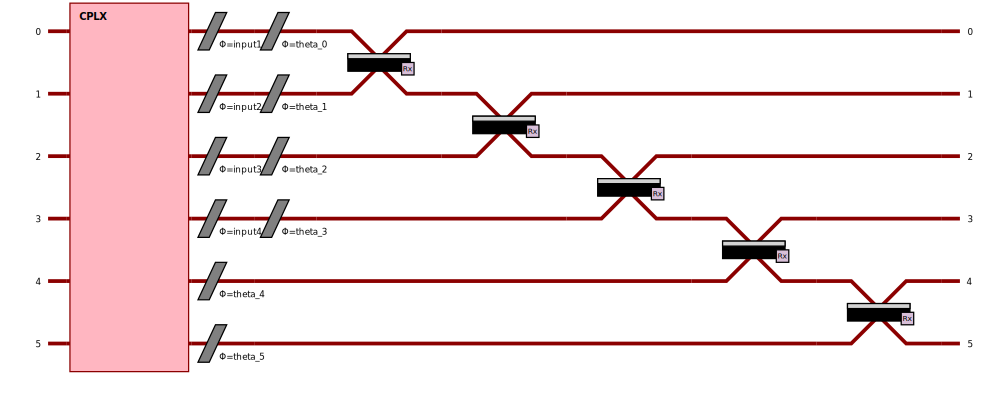

In [12]:
# you can observe your circuit
pcvl.pdisplay(builder_layer[0].circuit)

### Amplitude encoding with the Builder

The builder workflow can also support amplitude encoding: instead of feeding classical features that are angle-encoded into phase shifters, you provide a (normalized) complex amplitude vector that directly prepares the input superposition. Important points:

- Enable amplitude encoding when constructing the layer by passing `amplitude_encoding=True` to `QuantumLayer` (you must also provide `n_photons`).
- The effective input size depends on the chosen `computation_space` (FOCK / UNBUNCHED / DUAL_RAIL) and the circuit -- inspect `layer.input_size` or `len(layer.state_keys)` to build correctly-sized amplitude vectors.
- Inputs may be batched: pass a tensor of shape `(B, input_size)` to evaluate many amplitude states in one call; the layer will vectorise where possible.


Notes:
- When using amplitude encoding you cannot mix classical `input_parameters` with the amplitude tensor (the amplitude becomes the new input state).
- If you require dual-rail encoding, ensure the circuit has the correct mode pairing (dual-rail expects pairs of modes per logical qubit).

In [33]:

# We can build a layer without explicit encoding
builder = CircuitBuilder(n_modes=4)
builder.add_entangling_layer(trainable=True, name="U1")  # one trainable interferometer

amp_layer = QuantumLayer(
    builder=builder,
    n_photons=2,
    amplitude_encoding=True,
    computation_space=ComputationSpace.UNBUNCHED,  # or UNBUNCHED / DUAL_RAIL as appropriate
    dtype=torch.complex64,
)

# The computation space dimension equals the number of amplitudes we must provide.
# Here, we have 4 features, but we need to pad them to match the amplitude space.
# We provide a simple nn.Module to pad the input_state to match the amplitude space dimension.
num_states = amp_layer.input_size
print("Amplitude input size:", num_states)

class AmplitudePad(nn.Module):
    """Pad real features with zeros to match the amplitude space."""

    def __init__(self, target_dim: int):
        super().__init__()
        self.target_dim = target_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(torch.complex64)
        if x.shape[-1] > self.target_dim:
            raise ValueError(
                f"Expected at most {self.target_dim} features, got {x.shape[-1]}"
            )
        pad_width = self.target_dim - x.shape[-1]
        if pad_width > 0:
            padding = torch.zeros(*x.shape[:-1], pad_width, dtype=x.dtype, device=x.device)
            padded = torch.cat([x, padding], dim=-1)
        else:
            padded = x
        norms = torch.linalg.norm(padded, dim=-1, keepdim=True)
        norms = torch.clamp(norms, min=1e-12)
        return padded / norms

amplitude_encoder = AmplitudePad(num_states)

# Single example converted to amplitudes (first sample from the dataset)
single_state = amplitude_encoder(X_train[0].unsqueeze(0))
print("Single state shape:", single_state.shape)

# Single evaluation
output = amp_layer(single_state)
print("Layer output shape:", output.shape)

manual_layer = nn.Sequential(
    amplitude_encoder,
    amp_layer,
    LexGrouping(amp_layer.output_size, 3),
)

losses, train_acc, test_acc = run_experiment(manual_layer, epochs=120, lr=0.05)

trainable = sum(p.numel() for p in manual_layer.parameters() if p.requires_grad)
describe("Amplitude-encoded circuit", losses, train_acc, test_acc)
print(f"  trainable parameters: {trainable}")

# Batched evaluation: pad and normalise a batch of inputs
batch = amplitude_encoder(X_train[:8])
batched_out = amp_layer(batch)
print("Batched output shape:", batched_out.shape)


Amplitude input size: 6
Single state shape: torch.Size([1, 6])
Layer output shape: torch.Size([1, 6])
Amplitude-encoded circuit
  epochs: 120
  final loss: 0.9423
  train accuracy: 0.652
  test accuracy: 0.632
  trainable parameters: 12
Batched output shape: torch.Size([8, 6])


## 3. Hand-crafted Perceval circuit

When you need full control over the optical layout or to attach detectors/noise models via `perceval.Experiment`, build the circuit manually and pass it to `QuantumLayer`. This mode is useful when:

- you want custom detector models (threshold vs PNR) or realistic noise models;
- you require special component placements that a builder cannot express;
- you need to reuse the same `perceval.Experiment` across different training runs.

Remember: amplitude outputs are only available for noiseless unitary experiments. If you attach detectors or loss models, use `MeasurementStrategy.PROBABILITIES` or `MODE_EXPECTATIONS` instead.

In [13]:
modes = 6
# left generic interferometer
wl = pcvl.GenericInterferometer(
    modes,
    lambda i: pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_li{i}"))
    // pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_lo{i}")),
    shape=pcvl.InterferometerShape.RECTANGLE,
)
# data encoding
circuit = pcvl.Circuit(modes)
circuit.add(0, wl)
for mode in range(len(iris.feature_names)):
    circuit.add(mode, pcvl.PS(pcvl.P(f"input{mode}")))
# right generic interferometer
wr = pcvl.GenericInterferometer(
    modes,
    lambda i: pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_ri{i}"))
    // pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_ro{i}")),
    shape=pcvl.InterferometerShape.RECTANGLE,
)
circuit.add(0, wr)

manual_core = QuantumLayer(
    input_size=X_train.shape[1],
    circuit=circuit,
    input_state=[
        1,
        0,
        1,
        0,
        1,
        0,
    ],  # here, you can just precise the n_photons -> input_state = [1,1,1,0,0,0], 
    # you can also use pcvl.BasiscState to define more complex input states: # pcvl.BasicState([1,0,1,0,1,0])
    trainable_parameters=["theta"],
    input_parameters=["input"],
    dtype=X_train.dtype,
)

manual_layer = nn.Sequential(
    manual_core,
    LexGrouping(manual_core.output_size, 3),
)

losses, train_acc, test_acc = run_experiment(manual_layer, epochs=120, lr=0.05)
trainable = sum(p.numel() for p in manual_layer.parameters() if p.requires_grad)
describe("Manual Perceval circuit", losses, train_acc, test_acc)
print(f"  trainable parameters: {trainable}")

Manual Perceval circuit
  epochs: 120
  final loss: 0.7482
  train accuracy: 0.946
  test accuracy: 0.921
  trainable parameters: 60


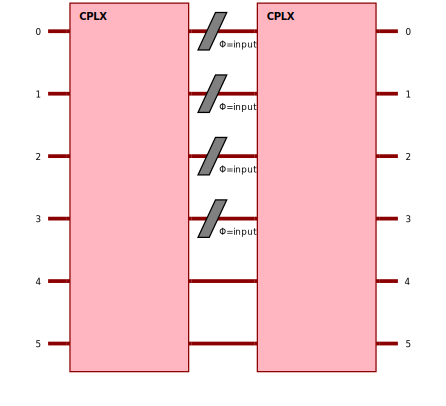

In [15]:
# display the circuit
pcvl.pdisplay(manual_core.circuit)

### Experiment-backed execution: detectors, noise and supported parameters

When you need to evaluate detector-level behaviour (threshold vs PNR detectors) or attach realistic noise models, wrap your `perceval.Circuit` into a `perceval.Experiment` and pass the experiment to `QuantumLayer`. The `QuantumLayer` will reuse the experiment measurement semantics (detectors, noise) and adapt available outputs accordingly.

Key behaviours and supported parameters

- detectors: assign per-mode detector types on the `Experiment` (e.g. `pcvl.Detector.threshold()` or `pcvl.Detector.pnr()`).
- noise / loss: `Experiment.noise` accepts `pcvl.NoiseModel` instances to model brightness, transmittance, dark counts, etc.
- measurement_strategy: when detectors or loss are present, amplitude outputs are not available. Use `PROBABILITIES` or `MODE_EXPECTATIONS`.
- shots / sampling_method: configure `shots` and `sampling_method` on `QuantumLayer` to control sampling-based evaluation (e.g. stochastic multinomial sampling).
- computation_space / no_bunching: choose `ComputationSpace` or the legacy `no_bunching` flag to control the simulated Fock basis (FOCK, UNBUNCHED/NO_BUNCHING, DUAL_RAIL).
- device / dtype: pass `device` and `dtype` to the layer so the underlying Torch-enabled compute graph is built on the correct device and precision.

Notes

- The experiment becomes the single source of truth for measurement semantics; any detector or noise changes on the `Experiment` will be respected by the `QuantumLayer`.
- Using `shots>0` returns sampled counts (stochastic). When training with gradient-based methods, sampled evaluation is typically disabled or handled with special autodiff backends; check `QuantumLayer` sampling docs for details.

In [34]:
# Build your perceval circuit as before
circuit = circuit  # reuse the `circuit` variable from the previous cell

# Create an Experiment that attaches noise and detectors
experiment = pcvl.Experiment(circuit)
experiment.noise = pcvl.NoiseModel(brightness=0.6, transmittance=0.8)
# Example: threshold detector on mode 0, PNR on mode 1
experiment.detectors[0] = pcvl.Detector.threshold()
experiment.detectors[1] = pcvl.Detector.pnr()

# Construct a QuantumLayer that reuses the experiment measurement semantics
experiment_layer = QuantumLayer(
    input_size=X_train.shape[1],
    experiment=experiment,
    input_state=[1, 1, 1, 0, 0, 0],
    input_parameters=["input"],
    trainable_parameters=["theta"],
    measurement_strategy=MeasurementStrategy.PROBABILITIES,
    computation_space=ComputationSpace.FOCK,
    device=None,                   # or torch.device("cuda") if available
    dtype=torch.float32,
)

# Downstream grouping and training is unchanged
model_with_noise = nn.Sequential(
    experiment_layer,
    LexGrouping(experiment_layer.output_size, 3),
    nn.Linear(3, 3),
)

# Run training as before
losses, train_acc, test_acc = run_experiment(model_with_noise, epochs=80, lr=0.05)
describe("Experiment-based layer with noise model", losses, train_acc, test_acc)
# we can observe a lower performance due to the noise model

Experiment-based layer with noise model
  epochs: 80
  final loss: 0.5774
  train accuracy: 0.812
  test accuracy: 0.842


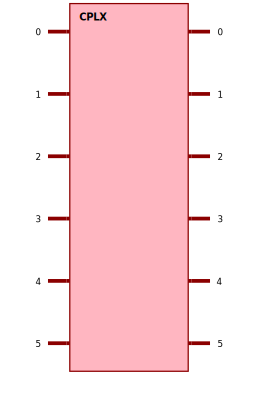

In [23]:
# you can visualize the circuit (same as before, but with noise and detectors that we cannot see here)
pcvl.pdisplay(experiment_layer.circuit)

## Conclusion

In this notebook we explored three practical ways to build and train photonic QuantumLayer modules:

- QuantumLayer.simple: a compact, ready-to-train factory useful for fast prototyping and capacity comparisons.
- CircuitBuilder: a declarative and repeatable API that separates encoding metadata from circuit structure and is the recommended path for training experiments.
- Hand-crafted Perceval circuits & Experiment: full control over optical layout, detectors and noise models; use this when you need detector-level semantics or to evaluate realistic experiment conditions.

Key takeaways:

- Choose your measurement strategy to match the downstream head (probabilities for dense heads, mode expectations to reduce parameters, amplitudes only for noiseless unitary simulations).
- Grouping (LexGrouping / ModGrouping) is an effective way to collapse the combinatorial Fock outputs into a compact classical representation.
- The computation space (FOCK / UNBUNCHED / DUAL_RAIL) controls the simulator's state basis and strongly impacts runtime and memory; prefer UNBUNCHED (no-bunching) when your circuits restrict photons to distinct modes.
- Amplitude encoding requires the full computation-space vector; pad missing amplitudes with zeros and re-normalise before passing data to the layer.
- When using experiments with detectors or noise, switch to sampling/probability outputs and consider shot noise when training or benchmarking.

Next steps and resources:

- Explore amplitude vs angle encoders and record how zero-padded amplitude normalisation influences optimisation.
- Benchmark computation spaces on your circuits to choose the best trade-off between accuracy and performance.
- Consult the documentation pages referenced in the notebook for deeper guidance on encoding, grouping and measurement strategies.

Happy prototyping — feel free to copy cells from this notebook into your own experiments and extend the examples to larger datasets or different circuit topologies.